In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import os 
import torch
import torch.nn as nn
import time
import pandas as pd
from sklearn import manifold, datasets
from sklearn.metrics import precision_recall_fscore_support, roc_curve, confusion_matrix
import glob
import itertools

## Load Data

In [12]:
y_pred = np.load("y_pred_val_1440chunks_21_everything_9.npy")
y_true = np.load("y_true_val_1440chunks_21_everything_9.npy")
tics = np.load("y_tic_val_1440chunks_21_everything_9.npy")
secs = np.load("y_sec_val_1440chunks_21_everything_9.npy")

mask = ~np.isnan(y_pred).any(axis=1)
y_pred = y_pred[mask]
y_true = y_true[mask]
tics = tics[mask]
secs = secs[mask]


files = glob.glob("top_1000_tic_ids/*")

# y_pred2 = np.load("y_pred_val_1440chunks_21_everything_10.npy")
# y_true2 = np.load("y_true_val_1440chunks_21_everything_10.npy")
# tics2 = np.load("y_tic_val_1440chunks_21_everything_10.npy")


In [13]:
np.shape(y_true)

(78426, 4)

## ROC + stats

## Unique tics EB test

In [14]:
y_pred = np.load("y_pred_val_16.npy")
y_true = np.load("y_true_val_16.npy")
tics = np.load("y_tic_val_16.npy")

y_pred2 = np.load("y_pred_val_17.npy")
y_true2 = np.load("y_true_val_17.npy")
tics2 = np.load("y_tic_val_17.npy")

y_pred3 = np.load("y_pred_val_18.npy")
y_true3 = np.load("y_true_val_18.npy")
tics3 = np.load("y_tic_val_18.npy")


y_pred4 = np.load("y_pred_val_19.npy")
y_true4 = np.load("y_true_val_19.npy")
tics4 = np.load("y_tic_val_19.npy")

# secs4 = np.load("secs_val_19.npy")
# y_pred4 = np.load("y_pred_val_19.npy")[np.where(secs4 !=35)[0]]
# y_true4 = np.load("y_true_val_19.npy")[np.where(secs4 !=35)[0]]
# tics4 = np.load("tic_val_19.npy")[np.where(secs4 !=35)[0]]
# secs4 = secs4[np.where(secs4 !=35)[0]]

In [15]:
y_pred = np.load("y_pred_test_16.npy")
y_true = np.load("y_true_test_16.npy")
tics = np.load("y_tic_test_16.npy")
secs = np.load("y_sec_test_16.npy")

y_pred2 = np.load("y_pred_test_17.npy")
y_true2 = np.load("y_true_test_17.npy")
tics2 = np.load("y_tic_test_17.npy")
secs2 = np.load("y_sec_test_17.npy")

y_pred3 = np.load("y_pred_test_18.npy")
y_true3 = np.load("y_true_test_18.npy")
tics3 = np.load("y_tic_test_18.npy")
secs3 = np.load("y_sec_test_18.npy")

y_pred4_test = np.load("y_pred_test_19.npy")
y_true4_test = np.load("y_true_test_19.npy")
tics4_test = np.load("y_tic_test_19.npy")
secs4_test = np.load("y_sec_test_19.npy")


y_pred5_test = np.load("y_pred_test_s49_19.npy")
y_true5_test = np.load("y_true_test_s49_19.npy")
tics5_test = np.load("y_tic_test_s49_19.npy")
secs5_test = np.load("y_sec_test_s49_19.npy")

y_pred6_test = np.concatenate((np.load("y_pred_test_s50_s53_s54_19.npy"),y_pred5_test,y_pred4_test))
y_true6_test = np.concatenate((np.load("y_true_test_s50_s53_s54_19.npy"),y_true5_test,y_true4_test))
tics6_test = np.concatenate((np.load("y_tic_test_s50_s53_s54_19.npy"),tics5_test,tics4_test))
secs6_test = np.concatenate((np.load("y_sec_test_s50_s53_s54_19.npy"),secs5_test,secs4_test))



In [40]:
y_pred6_test = np.load("y_pred_test_s50_s53_s54_19.npy")
y_true6_test = np.load("y_true_test_s50_s53_s54_19.npy")
tics6_test = np.load("y_tic_test_s50_s53_s54_19.npy")
secs6_test = np.load("y_sec_test_s50_s53_s54_19.npy")
x_test = np.load("x_test_s50_s53_s54_19.npy")

In [41]:
def find_cutoff(ypred,ytrue,tics,pc_score = 5, text = "yes"):
    
    labels_new_val = ytrue[:,:-1].copy()
    labels_new_val[:,-1] += ytrue[:,-1].copy()

    a, b, c = roc_curve(labels_new_val[:,1], ypred[:,1])

    my_score = []
    pcs_rems = []
    max_score = -10000
    tpr = []
    fpr = []
    
    for thr in c:
        
        pc_found_mask = np.where((ypred[:,1]<thr)&(labels_new_val[:,0] == 1))
        pc_found_tics = np.unique(tics[pc_found_mask])
        num_pc_found = len(pc_found_tics)

        pc_missed_mask = np.where((ypred[:,1]>=thr)&(labels_new_val[:,0] == 1))
        pc_missed_tics = np.unique(tics[pc_missed_mask])
        pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
        num_pc_missed = len(pc_missed_tics)

        other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,1]>=thr))
        other_found_tics = np.unique(tics[other_found_mask])
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
        num_other_found = len(other_found_tics)

        other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,1]<thr))
        other_missed_tics = np.unique(tics[other_missed_mask])
        other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
        num_other_missed = len(other_missed_tics)
        
        score = (num_pc_found - pc_score*num_pc_missed)/len(np.where(labels_new_val[:,0] == 1)[0]) + num_other_found/len(np.where(labels_new_val[:,1] == 1)[0])
        my_score.append(score)
        pcs_rems.append(num_pc_missed)
        
        tpr.append(num_other_found/(num_other_found+num_other_missed))
        fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))
        
        
        if score > max_score:
            max_score = score
            best_c = thr
            best_pc = num_pc_found
            best_other = num_other_found
            best_missed = num_pc_missed
            best_other_missed = num_other_missed
            best_pc_tics = pc_missed_tics
        
        
        
    if text == "yes":
        print(f"pcs found:{best_pc}, others found: {best_other}, pcs missed: {best_missed}, others missed: {best_other_missed}")
        print(f"pc missed tic: {best_pc_tics}")
        
    return best_c , tpr, fpr

def apply_cutoff(ypred,ytrue,tics,cutoff, text = "yes"):
    
    labels_new_val_test = ytrue[:,:-1].copy()
    labels_new_val_test[:,-1] += ytrue[:,-1].copy()

    pc_found_mask = np.where((ypred[:,1]<cutoff)&(labels_new_val_test[:,0] == 1))
    pc_found_tics = np.unique(tics[pc_found_mask])
    num_pc_found = len(pc_found_tics)
    pc_found_scores = ypred[pc_found_mask,1]

    pc_missed_mask = np.where((ypred[:,1]>=cutoff)&(labels_new_val_test[:,0] == 1))
    pc_missed_tics = np.unique(tics[pc_missed_mask])
    pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
    num_pc_missed = len(pc_missed_tics)
    pc_missed_scores = ypred[pc_missed_mask,1]

    other_found_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,1]>=cutoff))
    other_found_tics = np.unique(tics[other_found_mask])
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
    num_other_found = len(other_found_tics)
    other_found_scores = ypred[other_found_mask,1]

    other_missed_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,1]<cutoff))
    other_missed_tics = np.unique(tics[other_missed_mask])
    other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
    num_other_missed = len(other_missed_tics)
    other_missed_scores = ypred[other_missed_mask,1]
    
    eb_found_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,1]>=cutoff))
    eb_found_tics = np.unique(tics[eb_found_mask])
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_found_tics)]
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_missed_tics)]
    num_eb_found = len(eb_found_tics)
    
    eb_missed_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,1]>=cutoff))
    eb_missed_tics = np.unique(tics[eb_missed_mask])
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_found_tics)]
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_missed_tics)]
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,eb_found_tics)]
    num_eb_missed = len(eb_missed_tics)
    
    
    if text == "yes":
        print(f"pcs found:{num_pc_found},others found: {num_other_found}, pcs missed: {num_pc_missed}, others missed: {num_other_missed}")  
        print(f"pc missed tic: {pc_missed_tics}")
        print(f"ebs found: {num_eb_found}")
    
    return pc_found_tics, pc_missed_tics, other_found_tics, other_missed_tics, eb_found_tics, eb_missed_tics
        

In [7]:
def find_cutoff(ypred,ytrue,tics,ind,pc_score = 6, text = "yes"):
    
    if ind != 0: 
    
        labels_new_val = ytrue[:,:-1].copy()
        labels_new_val[:,-1] += ytrue[:,-1].copy()

        a, b, c = roc_curve(labels_new_val[:,ind], ypred[:,ind])

        my_score = []
        pcs_rems = []
        max_score = -10000
        tpr = []
        fpr = []
    
   
        print(ind)
        for thr in c:
            pc_found_mask = np.where((ypred[:,ind]<thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]>=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed = len(pc_missed_tics)

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found = len(other_found_tics)

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed = len(other_missed_tics)

            score = (num_pc_found - pc_score*num_pc_missed)/len(np.where(labels_new_val[:,0] == 1)[0]) + num_other_found/len(np.where(labels_new_val[:,1] == 1)[0])
            my_score.append(score)
            pcs_rems.append(num_pc_missed)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            if score > max_score:
                max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
    else:
        
        labels_new_val = ytrue[:,:-1].copy()
        labels_new_val[:,-1] += ytrue[:,-1].copy()

        a, b, c = roc_curve(labels_new_val[:,ind], ypred[:,ind])

        my_score = []
        pcs_rems = []
        max_score = -10000
        tpr = []
        fpr = []
            
        
        print(ind)
        for thr in c:

            pc_found_mask = np.where((ypred[:,ind]>thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]<=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed = len(pc_missed_tics)

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found = len(other_found_tics)

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed = len(other_missed_tics)

            score = (num_pc_found - pc_score*num_pc_missed)/len(np.where(labels_new_val[:,0] == 1)[0]) + num_other_found/len(np.where(labels_new_val[:,1] == 1)[0])
            my_score.append(score)
            pcs_rems.append(num_pc_missed)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            if score > max_score:
                max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
        
        
        
    if text == "yes":
        print(f"pcs found:{best_pc}, others found: {best_other}, pcs missed: {best_missed}, others missed: {best_other_missed}")
        print(f"pc missed tic: {best_pc_tics}")
        
    return best_c , tpr, fpr

In [8]:
c0, tpr0, fpr0 = find_cutoff(y_pred4,y_true4,tics4,0)
# c1, tpr1, fpr1 = find_cutoff(y_pred4,y_true4,tics4,1)
# c2, tpr2, fpr2 = find_cutoff(y_pred4,y_true4,tics4,2)

0


IndexError: index 53289 is out of bounds for axis 0 with size 53278

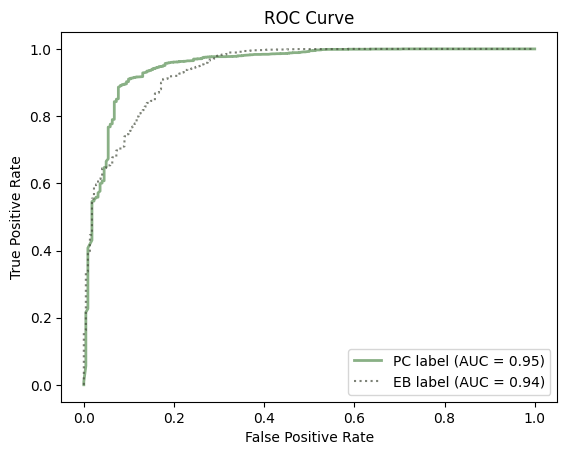

In [76]:
plt.figure()
plt.plot(fpr0,tpr0,label=f"PC label (AUC = {-np.trapz(tpr0,x=fpr0):.{2}f})",linewidth=2,color="#89b085")
plt.plot(fpr1,tpr1,label=f"EB label (AUC = {np.trapz(tpr1,x=fpr1):.{2}f})",linestyle = "dotted",color="#444c3c",alpha=0.7)
plt.plot(fpr2,tpr2,label=f"FP label (AUC = {np.trapz(tpr2,x=fpr2):.{2}f})",linestyle = "dashdot",color="#444c3c",alpha=0.7)
#plt.plot(fpr21,tpr21,label=f"21 AUC = {np.trapz(tpr21,x=fpr21):.{2}f}",color="green",alpha=0.7)
#plt.plot([0, 1], [0, 1], "--",color="#444c3c" ,label="AUC = 0.5")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
#plt.savefig("ROC_all.png",bbox_inches="tight")


In [5]:
def apply_cutoff(ypred,ytrue,tics,cutoff, text = "yes"):
    
    labels_new_val_test = ytrue[:,:-1].copy()
    labels_new_val_test[:,-1] += ytrue[:,-1].copy()

    pc_found_mask = np.where((ypred[:,0]>cutoff)&(labels_new_val_test[:,0] == 1))
    pc_found_tics = np.unique(tics[pc_found_mask])
    num_pc_found = len(pc_found_tics)
    pc_found_scores = ypred[pc_found_mask,1]

    pc_missed_mask = np.where((ypred[:,0]<=cutoff)&(labels_new_val_test[:,0] == 1))
    pc_missed_tics = np.unique(tics[pc_missed_mask])
    pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
    num_pc_missed = len(pc_missed_tics)
    pc_missed_scores = ypred[pc_missed_mask,1]

    other_found_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]<=cutoff))
    other_found_tics = np.unique(tics[other_found_mask])
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
    num_other_found = len(other_found_tics)
    other_found_scores = ypred[other_found_mask,1]

    other_missed_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]>cutoff))
    other_missed_tics = np.unique(tics[other_missed_mask])
    other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
    num_other_missed = len(other_missed_tics)
    other_missed_scores = ypred[other_missed_mask,1]
    
    eb_found_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]<=cutoff))
    eb_found_tics = np.unique(tics[eb_found_mask])
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_found_tics)]
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_missed_tics)]
    num_eb_found = len(eb_found_tics)
    
    eb_missed_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]<=cutoff))
    eb_missed_tics = np.unique(tics[eb_missed_mask])
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_found_tics)]
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_missed_tics)]
    eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,eb_found_tics)]
    num_eb_missed = len(eb_missed_tics)
    
    
    if text == "yes":
        print(f"pcs found:{num_pc_found},others found: {num_other_found}, pcs missed: {num_pc_missed}, others missed: {num_other_missed}")  
        print(f"pc missed tic: {pc_missed_tics}")
        print(f"ebs found: {num_eb_found}")
    
    return pc_found_tics, pc_missed_tics, other_found_tics, other_missed_tics, eb_found_tics, eb_missed_tics

In [6]:
secs = [50,53,54]
for i in secs:
    mask = np.where(secs6_test == i)
    pcf,pcm,of,om,ebf,ebm = apply_cutoff(y_pred6_test[mask[0]],y_true6_test[mask[0]],tics6_test[mask[0]],c0)
    print(len(ebm))

NameError: name 'c0' is not defined

In [ ]:
c, tpr, fpr = find_cutoff(y_pred4,y_true4,tics4)

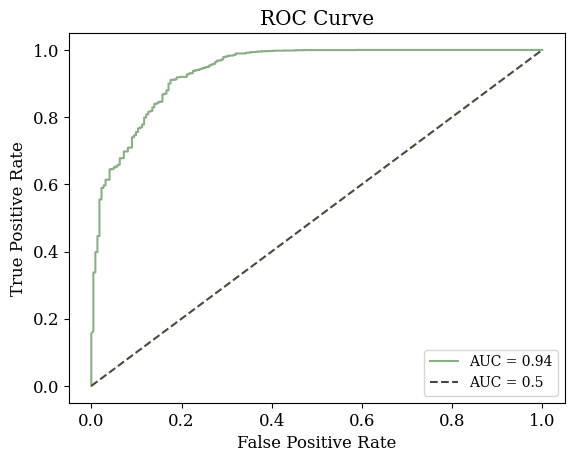

In [54]:
plt.figure()
plt.plot(fpr,tpr,label=f"AUC = {np.trapz(tpr,x=fpr):.{2}f}",color="#89b085")
plt.plot([0, 1], [0, 1], "--",color="#444c3c" ,label="AUC = 0.5")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("ROC.png",bbox_inches="tight")



In [4]:
mask = np.where(secs6_test == 50)
pcf,pcm,of,om,ebf,ebm = apply_cutoff(y_pred6_test[mask[0]],y_true6_test[mask[0]],tics6_test[mask[0]],c2)

x_pcf = []
x_of = []
pos_pcf = []
pos_of = []
tic_pcf = []
tic_of = []
times_pcf = []
times_of = []

files = glob.glob("light_curves_s50/*npy")
for file in files:
    tic = int(file[17:-7])
    lc = np.load(file,allow_pickle = True)
    if tic in pcf:
        x_pcf.append(lc[1])
        pos_pcf.append(lc[8])
        tic_pcf.append(tic)
        times_pcf.append(lc[0]-lc[0][0])
    if tic in ebf:
        x_of.append(lc[1])
        pos_of.append(lc[8])
        tic_of.append(tic)
        times_of.append(lc[0]-lc[0][0])

    
# good_ones = [28,21,22,23,24,26,41,43,60,70,80,90,100,102,104,105]


# x_pcf = [x_pcf[i] for i in good_ones]
# #x_of = [x_of[i] for i in good_ones]
# pos_pcf = [pos_pcf[i] for i in good_ones]
# #pos_of = [pos_of[i] for i in good_ones]
# tic_pcf = [tic_pcf[i] for i in good_ones]
# #tic_of = [tic_of[i] for i in good_ones]
# times_pcf = [times_pcf[i] for i in good_ones]
# #times_of = [times_of[i] for i in good_ones]

# # for i, x in enumerate(x_pcf[40:50]):
# #     plt.figure()
# #     plt.plot(x,".",markersize=1)
# #     plt.title(i)

NameError: name 'apply_cutoff' is not defined

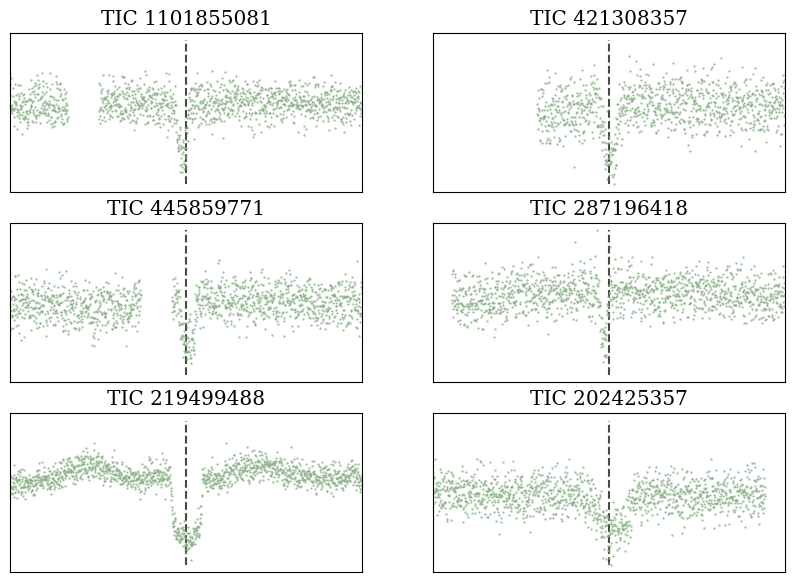

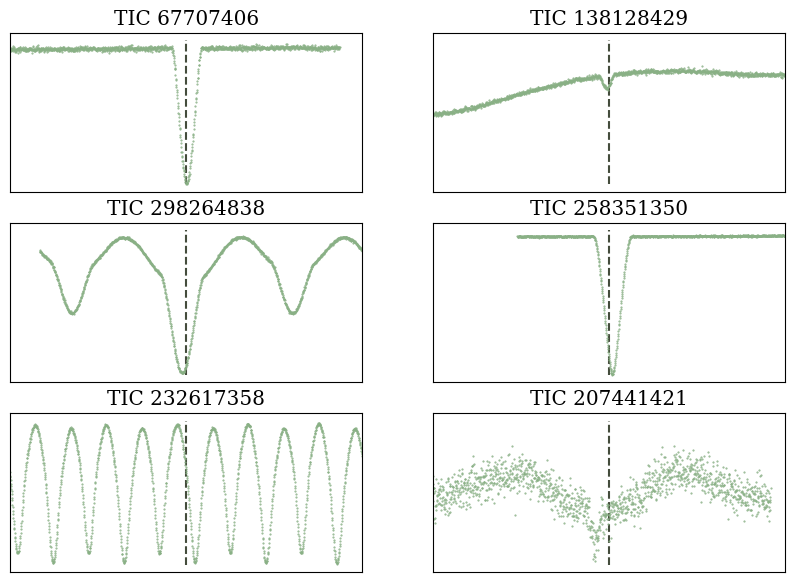

In [37]:
import matplotlib
plt.rc('font', family='serif',size=12)
matplotlib.rc('text')
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['text.latex.preamble'] = r'\math'

fig, axs = plt.subplots(3,2,figsize=(10,7))

cols = 2

for col in range(2):
    for row in range(3):
        axs[row][col].vlines(pos_pcf[row*cols + col][0],np.min(x_pcf[row*cols + col]),np.max(x_pcf[row*cols + col]),linestyle="dashed",color="#444c3c")
        axs[row][col].plot(times_pcf[row*cols + col],x_pcf[row*cols + col],".",markersize=1,color="#89b085")
        axs[row][col].set_xlim(pos_pcf[row*cols + col][0]-1,pos_pcf[row*cols + col][0]+1)
        #axs[row][col].set_title(row*cols + col)
                    
            
                    
            
        #axs[row][col].set_xlim(-0.2,0.2)
        #axs[row][col].set_ylim(-0.2,0.2)
        axs[row][col].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
        axs[row][col].set_title(f"TIC {tic_pcf[row*3 + col]}")
        
        
plt.savefig("tshirtpc.png",bbox_inches='tight')

fig, axs = plt.subplots(3,2,figsize=(10,7))

cols = 2

for col in range(2):
    for row in range(3):
        if row*cols + col != 4:
            axs[row][col].vlines(pos_of[50:][row*cols + col][0],np.min(x_of[50:][row*cols + col]),np.max(x_of[50:][row*cols + col]),linestyle="dashed",color="#444c3c")
            axs[row][col].plot(times_of[50:][row*cols + col],x_of[50:][row*cols + col],".",markersize=1,color="#89b085")
            axs[row][col].set_xlim(pos_of[50:][row*cols + col][0]-1,pos_of[50:][row*cols + col][0]+1)
        else:
            axs[row][col].vlines(pos_of[50:][10][0],np.min(x_of[50:][10]),np.max(x_of[50:][10]),linestyle="dashed",color="#444c3c")
            axs[row][col].plot(times_of[50:][10],x_of[50:][10],".",markersize=1,color="#89b085")
            axs[row][col].set_xlim(pos_of[50:][10][0]-1,pos_of[50:][10][0]+1)
            
        #axs[row][col].set_title(row*cols + col)
                    
            
                    
            
        #axs[row][col].set_xlim(-0.2,0.2)
        #axs[row][col].set_ylim(-0.2,0.2)
        axs[row][col].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
        axs[row][col].set_title(f"TIC {tic_of[row*3 + col]}")
        
plt.savefig("tshirteb.png",bbox_inches='tight')

[2.7548431e-05 9.6177089e-01 9.1963830e-06 ... 9.9981052e-01 2.8716801e-03
 1.6974691e-04]


(0.9, 1.1)

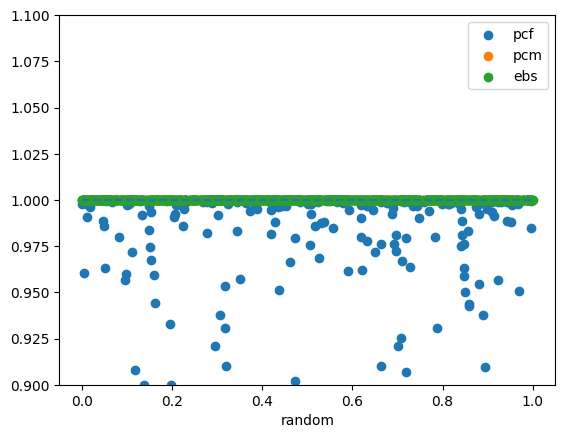

In [53]:
print(pcfs[0])


plt.figure()
plt.scatter(np.random.rand(len(pcfs[0])),pcfs[0],label="pcf")
plt.scatter(np.random.rand(len(pcms[0])),pcms[0],label="pcm")
plt.scatter(np.random.rand(len(ofs[0])),ofs[0],label="ebs")
#plt.scatter(np.random.rand(len(oms[0])),oms[0])
plt.hlines(c,0,1,linestyles="dashed")
plt.legend()
plt.xlabel("random")
plt.ylim((0.9,1.1))

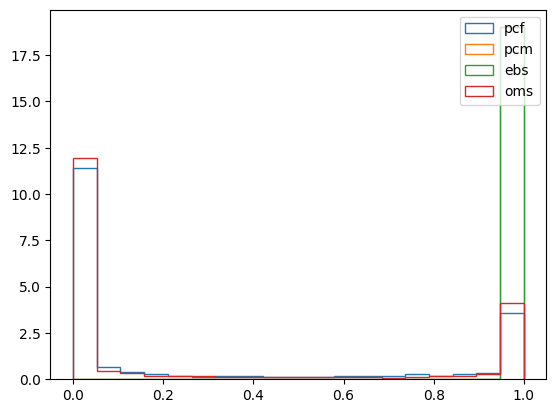

In [62]:
plt.figure()
plt.hist(pcfs[0],bins = np.linspace(0,1,20),label="pcf", histtype="step",density=True)
plt.hist(pcms[0],bins = np.linspace(0,1,20),label="pcm",histtype="step",density=True)
plt.hist(ofs[0],bins = np.linspace(0,1,20),label="ebs",histtype="step",density=True)
plt.hist(oms[0],bins = np.linspace(0,1,20),label="oms",histtype="step",density=True)
plt.legend()



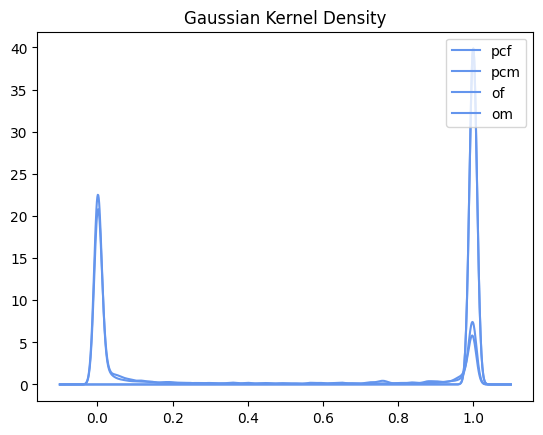

In [85]:
stuff = [pcfs,pcms,ofs,oms]
labels = ["pcf","pcm","of","om"]

from scipy.stats import norm
# Plot the 1D density curve for the gaussian kernel 
  
# Create a sample distribution 
N = 100
X = np.concatenate((np.random.normal(0, 1, int(0.6 * N)),  
                    np.random.normal(10, 1, int(0.4 * N))) 
                )[:, np.newaxis] 
X_plot = np.linspace(-0.1, 1.1, 1000)[:, np.newaxis] 

fig, ax = plt.subplots() 
for i,thing in enumerate(stuff):
    
    X = thing[0].reshape(-1, 1)

    # Calculate the true density 
    true_density = 0.6 * norm(0, 1).pdf(X_plot[:, 0]) + 0.4 * norm(10, 1).pdf(X_plot[:, 0]) 

    # Creating a figure 


    # Calculating the density using the gaussian kernel with bandwidth 0.5 
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X) 

    # Calculating the log of the probability density function 
    log_dens = kde.score_samples(X_plot) 

    # Plotting the density curve 
    ax.plot( 
        X_plot[:, 0], 
        np.exp(log_dens), 
        color="cornflowerblue", 
        linestyle="-", 
        label=f"{labels[i]}"
    ) 
  
# Set the title, x and y labels of the plot 
ax.set_title("Gaussian Kernel Density") 
#ax.set_xlim(-4, 15) 
#ax.set_ylim(0, 0.3) 
#ax.grid(True) 
ax.legend(loc='upper right') 
  
# Display the plot 
plt.show()

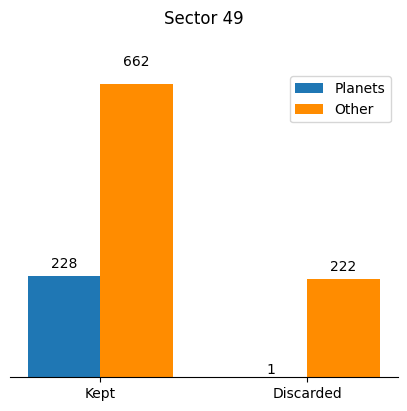

In [97]:
N = 2
x = np.arange(N)  # the x locations for the groups
width = 0.35

y1 = [len(pcf), len(pcm)]
y2 = [len(om), len(of)]

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

rects1 = ax.bar(x, y1, width, color='tab:blue')
rects2 = ax.bar(x+width, y2, width, color='darkorange')


#ax.bar(x, y1, width=0.3, color='tab:blue', align='center')
#ax.bar(x+width, y2, width=0.3, color='tab:green', align='center')

#ax.set_ylabel('Number of TIC IDs')
ax.set_xticks(x+width/2)
ax.set_xticklabels( ('Kept', 'Discarded') )
ax.legend( (rects1[0], rects2[0]), ('Planets', 'Other') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title("Sector 49",y=1.12)

plt.show()

In [9]:
def find_cutoff(ypred,ytrue,tics,pc_score = 5, text = "yes"):
    
    labels_new_val = ytrue[:,:-1].copy()
    labels_new_val[:,-1] += ytrue[:,-1].copy()

    a, b, c = roc_curve(labels_new_val[:,0], ypred[:,0])

    my_score = []
    pcs_rems = []
    max_score = -10000
    best_other = 0
    
    for thr in c:
        
        pc_found_mask = np.where((ypred[:,0]>=thr)&(labels_new_val[:,0] == 1))
        pc_found_tics = np.unique(tics[pc_found_mask])
        num_pc_found = len(pc_found_tics)

        pc_missed_mask = np.where((ypred[:,0]<thr)&(labels_new_val[:,0] == 1))
        pc_missed_tics = np.unique(tics[pc_missed_mask])
        pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
        num_pc_missed = len(pc_missed_tics)

        other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,0]<thr))
        other_found_tics = np.unique(tics[other_found_mask])
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
        num_other_found = len(other_found_tics)

        other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,0]>=thr))
        other_missed_tics = np.unique(tics[other_missed_mask])
        other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
        num_other_missed = len(other_missed_tics)
        
        #score = (num_pc_found - pc_score*num_pc_missed)/len(np.where(labels_new_val[:,0] == 1)[0]) + num_other_found/len(np.where(labels_new_val[:,1] == 1)[0])
        #my_score.append(score)
        #pcs_rems.append(num_pc_missed)
        #if score > max_score:
        if num_other_found > best_other & num_pc_missed < 2 :
            print("a")
            #max_score = score
            best_c = thr
            best_pc = num_pc_found
            best_other = num_other_found
            best_missed = num_pc_missed
            best_other_missed = num_other_missed
            best_pc_tics = pc_missed_tics
        
        
        
    if text == "yes":
        print(f"pcs found:{best_pc}, others found: {best_other}, pcs missed: {best_missed}, others missed: {best_other_missed}")
        print(f"pc missed tic: {best_pc_tics}")
        
    return best_c 

def apply_cutoff(ypred,ytrue,tics,cutoff, text = "yes"):
    
    labels_new_val_test = ytrue[:,:-1].copy()
    labels_new_val_test[:,-1] += ytrue[:,-1].copy()

    pc_found_mask = np.where((ypred[:,0]>cutoff)&(labels_new_val_test[:,0] == 1))
    pc_found_tics = np.unique(tics[pc_found_mask])
    num_pc_found = len(pc_found_tics)

    pc_missed_mask = np.where((ypred[:,0]<=cutoff)&(labels_new_val_test[:,0] == 1))
    pc_missed_tics = np.unique(tics[pc_missed_mask])
    pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
    num_pc_missed = len(pc_missed_tics)

    other_found_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]<=cutoff))
    other_found_tics = np.unique(tics[other_found_mask])
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
    other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
    num_other_found = len(other_found_tics)

    other_missed_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]>cutoff))
    other_missed_tics = np.unique(tics[other_missed_mask])
    other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
    num_other_missed = len(other_missed_tics)
    
    eb_found_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]<=cutoff))
    eb_found_tics = np.unique(tics[eb_found_mask])
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_found_tics)]
    eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_missed_tics)]
    num_eb_found = len(eb_found_tics)
    
    if text == "yes":
        print(f"pcs found:{num_pc_found},others found: {num_other_found}, pcs missed: {num_pc_missed}, others missed: {num_other_missed}")  
        print(f"pc missed tic: {pc_missed_tics}")
        print(f"ebs found: {num_eb_found}")
        

In [10]:
c = find_cutoff(y_pred4,y_true4,tics4)

IndexError: index 53289 is out of bounds for axis 0 with size 53278

In [ ]:
apply_cutoff(y_pred5_test,y_true5_test,tics5_test,c)

In [ ]:
labels_new_val = y_true[:,:-1].copy()
labels_new_val[:,-1] += y_true[:,-1].copy()

# labels_new_val = y_true[:,:-2].copy()
# labels_new_val[:,-1] += y_true[:,-1].copy()
# labels_new_val[:,-1] += y_true[:,-2].copy()


# y_pred_new = y_pred[:,:-1].copy()
# y_pred_new[:,-1] += y_pred[:,-1].copy()


#print(confusion_matrix(np.argmax(labels_new_val,axis=1), np.argmax(y_pred,axis=1)))

#print(precision_recall_fscore_support(np.argmax(labels_new_val,axis=1), np.argmax(y_pred,axis=1), average=None))

a, b, c = roc_curve(labels_new_val[:,1], y_pred[:,1])

# plt.figure()
# plt.plot(a,b,label="17")
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
# plt.axis("square")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\nEB vs the rest")
# plt.legend()
#plt.savefig("ROC_fluxbkg_vs_fluxonly.png")


thr = 20


other = y_pred[y_pred[:,1]<c[thr]]
eb = y_pred[y_pred[:,1]>=c[thr]]


correct = 0
cont = 0
ebs = 0
missed = 0 
others = 0
pcs_in_eb = 0

for i in range(len(y_pred)):
  if y_pred[i,1] < c[thr] and labels_new_val[i,1] == 0:
    correct = correct + 1
    others = others + 1
  elif y_pred[i,1] >= c[thr] and labels_new_val[i,1] == 1:
    correct = correct + 1
    ebs = ebs + 1
  elif y_pred[i,1] >= c[thr] and labels_new_val[i,1] == 0:
    cont = cont + 1
    if labels_new_val[i,0] == 1:
        pcs_in_eb = pcs_in_eb + 1
    
  elif y_pred[i,1] < c[thr] and labels_new_val[i,1] == 1:
    missed = missed + 1


accuracy = ebs/len(labels_new_val[labels_new_val[:,1]==1])
contamination = cont/(len(eb))
print(f"percent of ebs found: {accuracy}, contamination: {contamination}, ebs found: {ebs}, ebs missed: {missed}, false positives: {cont}")

print(f"% of FP and PCs removed: {(others)*100/(len(y_true[labels_new_val[:,0]==0]))}")
print(f"num removed: {others}")
print(f"% planets discarded as ebs: {pcs_in_eb/len(y_true[labels_new_val[:,0]==1])}")
print(f"planets discarded as ebs: {pcs_in_eb}")

# my_score = []
# max_score = -1
# for thr in c:
#     #for thr2 in c2:

#     ebs = len(np.where((y_pred[:,1] >= thr)&(labels_new_val[:,1] == 1))[0])
#     missed = len(np.where((y_pred[:,1] < thr)&(labels_new_val[:,1] == 1))[0])
#     pcs_in_eb = len(np.where((y_pred[:,1] >= thr)&(labels_new_val[:,0] == 1))[0])
#     score = ebs/len(np.where(labels_new_val[:,1] == 1)[0])-2.5*(pcs_in_eb/len(np.where(labels_new_val[:,0] == 1)[0]))#-(missed/len(np.where(labels_new_val[:,1] == 1)[0]))
#     my_score.append(score)
#     if score > max_score:
#         max_score = score
#         best_c = thr
#         best_ebs = ebs
#         best_missed = missed
#         best_pcs_in_eb = pcs_in_eb


#     #plt.plot(thr,ebs-pcs_in_eb-missed,".")

# plt.figure()
# plt.plot(my_score)
# print(f"found ebs: {best_ebs}, missed ebs: {best_missed}, pcs removed: {best_pcs_in_eb}")    

# a2, b2, c2 = roc_curve(labels_new_val[:,0], y_pred_new[:,0])

# my_score2 = []
# max_score2 = -100
# best_pcs_in_eb2 = pcs_in_eb
# for thr2 in c2:
#     #for thr2 in c2:
    
#     #ebs2 = len(np.where((y_pred_new[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred_new[:,0] <= thr2))[0])+len(np.where((y_pred_new[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred_new[:,0] > thr2))[0])
#     #ebs2 = len(np.where((y_pred_new[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred_new[:,0]<=thr2))[0]) #+ len(np.where((y_pred_new[:,1] < best_c)&(labels_new_val[:,1] == 1)&(y_pred_new<=thr2))[0])
#     #missed2 = len(np.where((y_pred_new[:,1] < best_c)&(labels_new_val[:,1] == 1)))+len(np.where((y_pred_new[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred_new[:,0]>thr2))[0])#&(y_pred_new[:,0]>thr2))[0])#+len(np.where((y_pred_new[:,1] < best_c)&(labels_new_val[:,1] == 1)&(y_pred_new[:,0]<=thr2))[0])
#     #pcs_in_eb2 = len(np.where((y_pred_new[:,1] >= best_c)&(labels_new_val[:,0] == 1)&(y_pred_new[:,0]<=thr2))[0])#+len(np.where((y_pred_new[:,1] < best_c)&(labels_new_val[:,0] == 1)&(y_pred_new[:,0]  thr2))[0])
#     pcs_in_eb2 = len(np.where((labels_new_val[:,0]==1)&(y_pred_new[:,1]>=best_c)&(y_pred_new[:,0]<=thr2)))
#     ebs2 = len(np.where((labels_new_val[:,1]==1)&(y_pred_new[:,1]>=best_c)&(y_pred_new[:,0]<=thr2)))
#     score2 = ebs2/len(np.where(labels_new_val[:,1] == 1)[0])-(pcs_in_eb2/len(np.where(labels_new_val[:,0] == 1)[0]))#-(missed2/len(np.where(labels_new_val[:,1] == 1)[0]))
#     my_score2.append(score2)
#     if score2 > max_score2:
#     #if pcs_in_eb2 < best_pcs_in_eb2:
#         max_score2 = score2
#         best_c2 = thr2
#         best_ebs2 = ebs2
#         best_missed2 = missed2
#         best_pcs_in_eb2 = pcs_in_eb2
        
        
# plt.figure()
# plt.plot(my_score2)
# print(f"found ebs: {best_ebs2}, missed ebs: {best_missed2}, pcs removed: {best_pcs_in_eb2}") 

In [ ]:
labels_new_val = y_true4[:,:-1].copy()
labels_new_val[:,-1] += y_true4[:,-1].copy()

# pc_as_eb_index = []
# eb_as_eb_index = []

# best_c2 = 3e-7

# pc_as_pc_index = np.where((y_pred[:,1] < best_c)&(labels_new_val[:,0] == 1)|(y_pred[:,1] >= best_c)&(labels_new_val[:,0] == 1)&(y_pred[:,0] < best_c2))#&(y_pred_new[:,0] > best_c2)) 

# pc_as_eb_index = np.where((y_pred[:,1] >= best_c)&(labels_new_val[:,0] == 1)&(y_pred[:,0] < best_c2)) 

# eb_as_eb_index = np.where((y_pred[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred[:,0] < best_c2))

# eb_as_pc_index = np.where((y_pred[:,1] < best_c)&(labels_new_val[:,1] == 1)|(y_pred[:,1] >= best_c)&(labels_new_val[:,1] == 1)&(y_pred[:,0] < best_c2))#&(y_pred_new[:,0] > best_c2))

# other = np.where((y_pred_new[:,1] >= best_c)&(y_pred_new[:,0] >= best_c2)) 

#num = 5e-11

pc_as_eb_index = np.where((y_pred4[:,1] >= best_c)&(labels_new_val[:,0]==1))#&(y_pred[:,0]<num))
eb_as_eb_index = np.where((y_pred4[:,1] >= best_c)&(labels_new_val[:,0]==0))#&(y_pred[:,0]<num))

found_pc = np.where((y_pred4[:,1] < best_c)&(labels_new_val[:,0]==1))#&(y_pred[:,0]<num))
eb_as_pc_index = np.where((y_pred4[:,1] < best_c)&(labels_new_val[:,0]==0))#&(y_pred[:,0]<num))
#found_eb = np.where((y_pred4[:,1] >= best_c)&(labels_new_val[:,1]==1))#&(y_pred[:,0]<num))


#fp_as_eb_index = []

# for i in range(len(y_true)):
#     if np.argmax(labels_new_val,axis=1)[i] == 0 and np.argmax(y_pred,axis=1)[i] == 1:
#         pc_as_eb_index.append(i)
#     if np.argmax(labels_new_val,axis=1)[i] == 1 and np.argmax(y_pred,axis=1)[i] == 1:
#         eb_as_eb_index.append(i)
# #     if np.argmax(labels_new_val,axis=1)[i] == 2 and np.argmax(y_pred,axis=1)[i] == 1:
# #         fp_as_eb_index.append(i)
    

pc_as_eb_score = y_pred[pc_as_eb_index]

pc_as_eb_tics = tics[pc_as_eb_index]

#mask = np.where(pc_as_eb_score[:,0]>1e-2)

#pc_as_eb_tics = pc_as_eb_tics[mask]


print("unique pcs as ebs (tics): ", len(np.unique(pc_as_eb_tics)))

eb_as_eb_score = y_pred[eb_as_eb_index]
eb_as_eb_tics = tics[eb_as_eb_index]

#mask = np.where(eb_as_eb_score[:,1]>=best_c)

#eb_as_eb_tics = eb_as_eb_tics[mask]

print("unique ebs as ebs (tics): ", len(np.unique(eb_as_eb_tics)))

# fp_as_eb_score = y_pred[fp_as_eb_index]
# fp_as_eb_tics = tics[fp_as_eb_index]

# mask = np.where((fp_as_eb_score[:,1]>=best_c)&(fp_as_eb_score[:,2]>0))

# fp_as_eb_tics = fp_as_eb_tics[mask]

# print("unique fp as eb (tics): ", len(np.unique(fp_as_eb_tics)))
eb_as_pc_score = y_pred[eb_as_pc_index]
eb_as_pc_tics = tics[eb_as_pc_index]

print("unique ebs as pc (tics): ", len(np.unique(eb_as_pc_tics)))

pc_as_pc_score = y_pred[found_pc]
pc_as_pc_tics = tics[found_pc]

print("unique pc as pc (tics): ", len(np.unique(pc_as_pc_tics)))



np.where((y_pred4[:,1] >= best_c)&(labels_new_val[:,0]==1))

In [ ]:
print(len(np.unique(tics)))
count=0
for tic in np.unique(eb_as_pc_tics):
    if tic in pc_as_pc_tics:
        count+=1


In [ ]:
np.unique(pc_as_eb_tics)

## Make current vs cnn top 500

In [ ]:
#planet_score = y_pred[:,0]

df = pd.DataFrame({"sector":secs[:,0],"tic":tics[:,0],"true":y_true[:,1],"pred":y_pred[:,1]})

top_500_cnn = []
top_500_current = []

files = glob.glob("top_1000_tic_ids/*")

for file in files:
    
    sector = int(file[30:-4])
    
#     for i in pd.read_csv(file)["db_count_weighted"]:
#         current_top_1000_scores.append(np.max(eval(i)))
    
    df_sec = df[df['sector'] == sector]
    
    df_sec_sorted  = df_sec.sort_values('pred', ascending=False)
    
    df_sec_sorted_unique = df_sec_sorted.drop_duplicates(subset='tic', keep="first")
    
    num = len(df_sec_sorted_unique)
    
    num=500
    
    df_sec_sorted_unique_crop = df_sec_sorted_unique[:num]
    
    current_top_1000 = pd.read_csv(file)
    
    current_top_crop = current_top_1000#[:num]
    current_top_crop_in_df = df_sec_sorted_unique[df_sec_sorted_unique["tic"].isin(current_top_crop["TIC_ID"])][:num]
    
    if len(df_sec_sorted_unique) > 0 :
        top_500_cnn.append(df_sec_sorted_unique_crop["true"])
        top_500_current.append(current_top_crop_in_df["true"])
        
        

In [ ]:
# precision, recall metrics for real planets
# recovery rate as a function of rank

from sklearn import metrics

fig , axs = plt.subplots(1,2)

cnn_scores = top_500_cnn[0]
current_scores = top_500_current[0]

ranks = np.arange(1, len(current_scores))
print(len(current_scores))
recs = np.zeros(len(ranks))
precs = np.zeros(len(ranks))
for i, rank in enumerate(ranks):
    prec = metrics.precision_score(current_scores[:rank], np.ones(rank), average="binary")  # taking the top k to be positive predictions
    precs[i] = prec
    rec = np.sum(current_scores[:rank]) / np.sum(current_scores)
    recs[i] = rec

line, = axs[0].plot(ranks, recs, linestyle = 'solid',color="blue",label="current")  #, total={len(cls_df)}")
axs[1].plot(ranks, precs, linestyle = 'solid',color="blue")

ranks = np.arange(1, len(cnn_scores))
print(len(cnn_scores))
recs = np.zeros(len(ranks))
precs = np.zeros(len(ranks))

for i, rank in enumerate(ranks):
    prec = metrics.precision_score(cnn_scores[:rank], np.ones(rank), average="binary")  # taking the top k to be positive predictions
    precs[i] = prec
    rec = np.sum(cnn_scores[:rank]) / np.sum(cnn_scores)
    recs[i] = rec

line, = axs[0].plot(ranks, recs, linestyle = 'solid',color="red",label="CNN")  #, total={len(cls_df)}")
axs[1].plot(ranks, precs, linestyle = 'solid',color="red") 
axs[0].legend()
    


# formatting
axs[0].set_title("Fractional Recovery Rate")
axs[0].set_xlabel("Rank")
axs[0].set_ylabel("Recall")
# axs[0].set_xlim(-0.05,1.05)
#axs[0].set_ylim(-0.05, 0.7)
#axs[0].legend(title="Candidate")
axs[0].set_aspect(1./axs[0].get_data_ratio())

axs[1].set_title("Precision")
axs[1].set_xlabel("Rank")
axs[1].set_ylabel("Precision")
# axs[1].set_xlim(-0.05,1.05)
#axs[1].set_ylim(-0.05, 1)
#axs[1].legend(title="Candidate")
axs[1].set_aspect(1./axs[1].get_data_ratio())


plt.tight_layout()
plt.show()

### top_500_cnn

In [2]:
files = glob.glob("light_curves_s50/*npy")

tics = [207468071,335743775,156067195,219866209,198554264,459252372,441739020,421308357,115011023,43137420,383676981,229765298,232612416,199661915,229979731,445859771,165499205,159871619,287196418,1102276931,155988736,390651552,420110967,309828087]

x_pcf = []
x_of = []
pos_pcf = []
pos_of = []
tic_pcf = []
tic_of = []
times_pcf = []
times_of = []

for tic in tics:
    filename = "light_curves_s50/" + str(tic) +"_lc.npy"
    #tic = int(file[17:-7])
    #if tic in tics:
    lc = np.load(filename,allow_pickle = True)
    x_pcf.append(lc[1])
    pos_pcf.append(lc[8])
    tic_pcf.append(tic)
    times_pcf.append(lc[0]-lc[0][0])

    x_of.append(lc[1])
    pos_of.append(lc[8])
    tic_of.append(tic)
    times_of.append(lc[0]-lc[0][0])


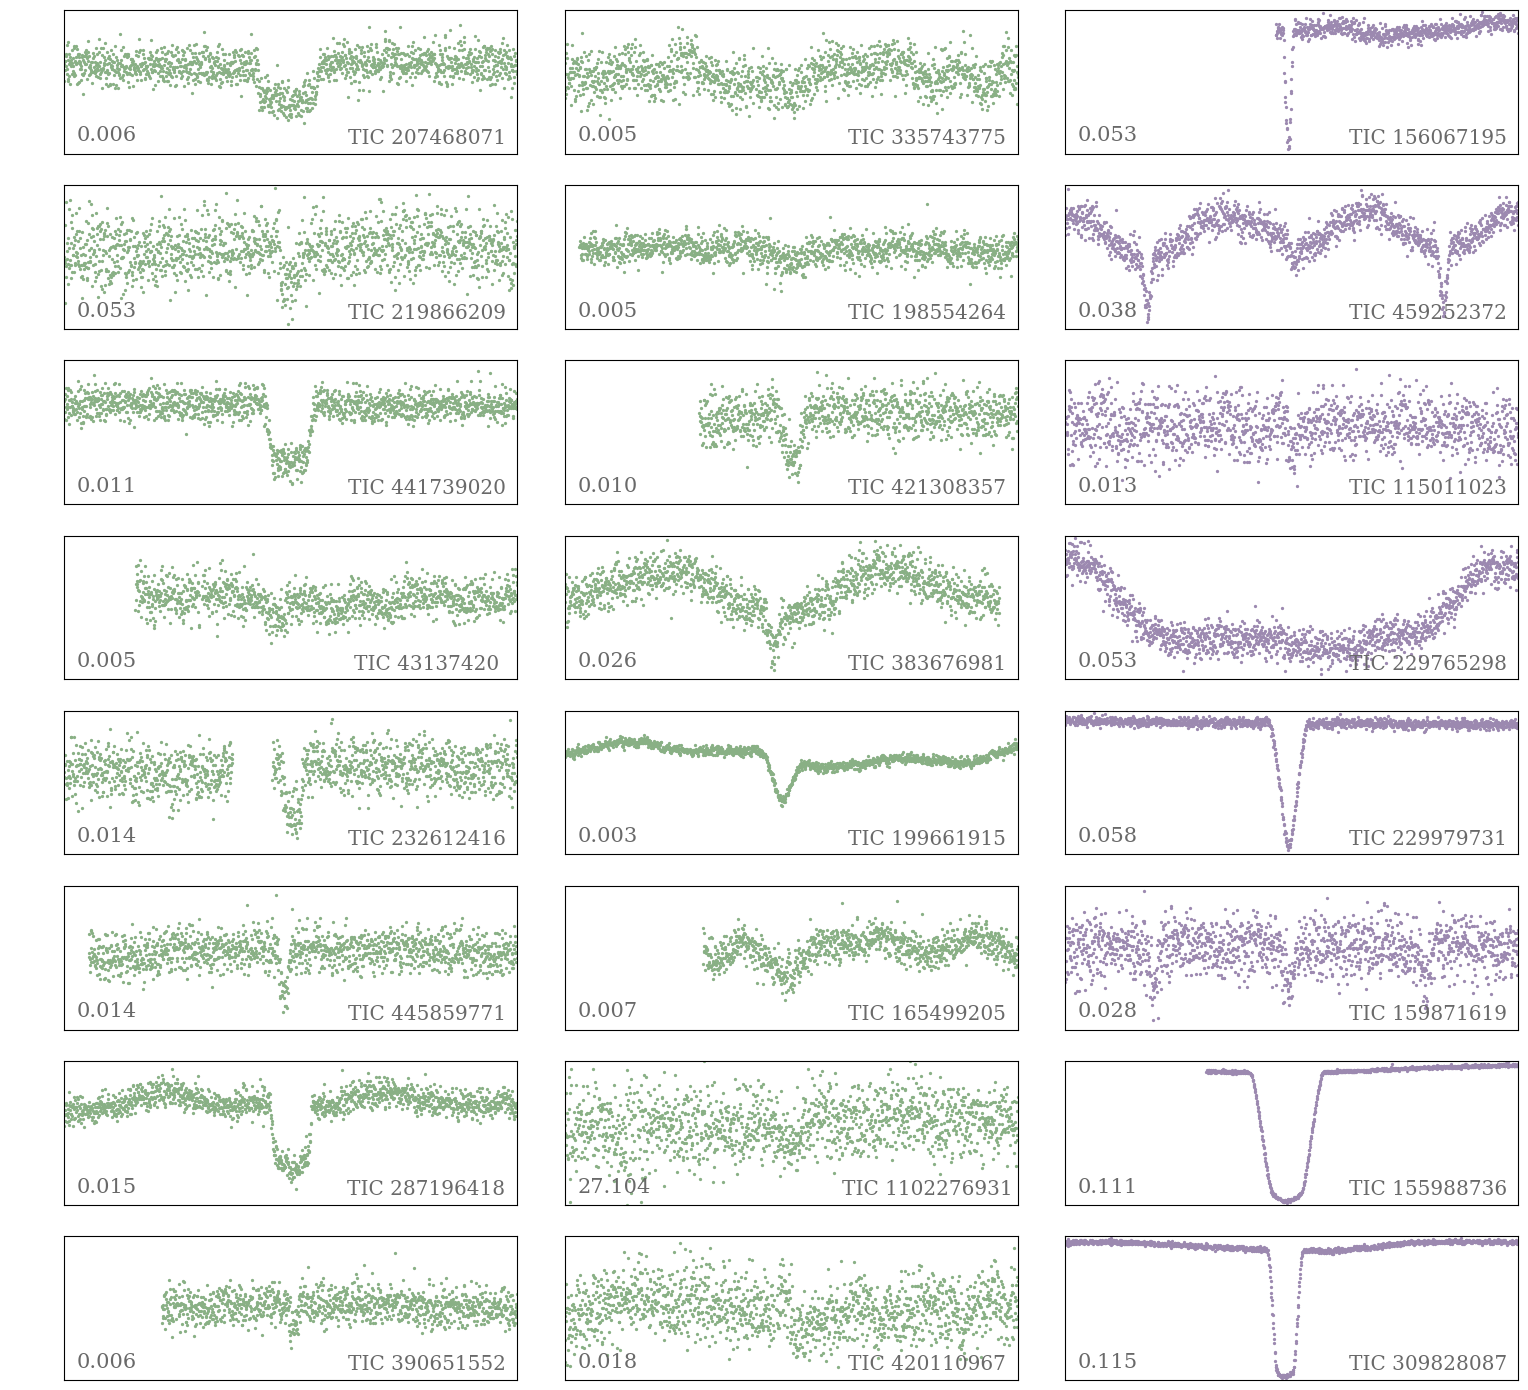

In [69]:
import matplotlib
plt.rc('font', family='serif',size=12)
matplotlib.rc('text')
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['text.latex.preamble'] = r'\math'

fig, axs = plt.subplots(8,3,figsize=(15,14))
fig.tight_layout(pad=-0.1)
cols = 3

for col in range(3):
    for row in range(8):
        
        time = times_pcf[row*cols + col]
        x = x_pcf[row*cols + col]/np.median(x_pcf[row*cols + col])
        pos = pos_pcf[row*cols + col][0]                                   
        
        if col != 2:
            #axs[row][col].vlines(pos_pcf[row*cols + col][0],np.min(x_pcf[row*cols + col]/np.median(x_pcf[row*cols + col])),np.max(x_pcf[row*cols + col]/np.median(x_pcf[row*cols + col])),linestyle="dashed",color="#444c3c")
            axs[row][col].plot(time,x,".",markersize=2.7,color="#89b085")
        else:
            #axs[row][col].vlines(pos_pcf[row*cols + col][0],np.min(x_pcf[row*cols + col]/np.median(x_pcf[row*cols + col])),np.max(x_pcf[row*cols + col]/np.median(x_pcf[row*cols + col])),linestyle="dashed",color="#444c3c")
            axs[row][col].plot(time,x,".",markersize=2.7,color="#9c89b0")
        
        axs[row][col].set_xlim(pos-1,pos+1)
        window_mask = np.where((time>(pos-1))&(time<(pos+1)))[0]
        axs[row][col].plot([],color='none', label="{:.3f}".format(-np.min(x[window_mask])+np.max(x[window_mask])))
        
        axs[row][col].legend(frameon=False,bbox_to_anchor=(-0.12, 0), loc="lower left", labelcolor="dimgray",borderaxespad=0,fontsize=15)
        axs[row][col].set_ylim(np.min(x[window_mask])-0.002*np.abs(np.min(x[window_mask])),1.001*np.max(x[window_mask]))
        axs[row][col].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
        axs[row][col].set_title(f"TIC {tic_pcf[row*3 + col]}",y=0.01,x=0.8,color="dimgray")
        
plt.savefig("classification.png",bbox_inches="tight")